In [1]:
import faiss		
import matplotlib.pyplot as	plt
import nltk
import numpy as	np
import pandas as pd
import random			
import re		
import seaborn as sns
import spacy		
import statistics		
import string		
import time	
from nltk.corpus import	stopwords, wordnet
from nltk.stem import	PorterStemmer, SnowballStemmer
from nltk.tokenize import	word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import	TfidfVectorizer
from tqdm import tqdm
	
pd.options.display.float_format = '{:,.4f}'.format
tqdm.pandas()

sns.set_palette('gray')
sns.set_style("whitegrid")

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

c:\Users\annap\miniconda3\envs\ri-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
SnowballStemmer.languages

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

# Read  Files

## Functions

In [3]:
def extract_informations(filename:str)->dict:

    data = {}
    id_actual = None
    information = ""

    try:
        with open(filename, "r", encoding='ansi') as file:
            for line in file:
                if line.startswith("RN"): #  ID
                    # if haven an information before, save in a dictionary 
                    if id_actual and information:
                        data[id_actual] = information
                        information = ""
                    # get id next second word 
                    id_actual = line.split()[1]
                elif line.startswith(("TI", "MJ", "MN", "AB", "EX")) and id_actual:
                    information += line[3:].strip()
                    while True:
                        next_line = file.readline()
                        if not next_line or re.match(r'\b[A-Z]{2}\s', next_line):
                            break
                        information += " " + next_line.strip()
            # add last information at dictionary
            if id_actual and information:
                data[id_actual] = information
    except FileNotFoundError:
        print("File not founded.")

    return data

def read_file_query(file_path:str)->dict:
 
    data = {'QN': [], 'QU': [], 'NR': [], 'RD': []}

    qn_id = None
    qu_text = None
    nr_number = None
    rd_list = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('RD'):
                rd_list = [int(x) for x in re.findall(r'\d+', line)]
                while True:
                    try:
                        next_line = next(file)
                        if next_line.startswith('QN'):
                            # Save acumulated
                            if qn_id is not None:
                                data['QN'].append(qn_id)
                                data['QU'].append(qu_text)
                                data['NR'].append(nr_number)
                                data['RD'].append(rd_list)

                            # Restart variables to next "QN"
                            qn_id = int(re.search(r'\d+', next_line).group())
                            qu_text = None
                            nr_number = None
                            rd_list = []
                            break
                        rd_list.extend([int(x) for x in re.findall(r'\d+', next_line)])
                    except StopIteration:
                        break
            elif line.startswith('QN'):
                qn_id = int(re.search(r'\d+', line).group())
            elif line.startswith('QU'):
                qu_text = line[3:].strip()
            elif line.startswith('NR'):
                nr_number = int(re.search(r'\d+', line).group())

    
    if qn_id is not None:
        data['QN'].append(qn_id)
        data['QU'].append(qu_text)
        data['NR'].append(nr_number)
        data['RD'].append(rd_list)

    df = pd.DataFrame(data)
    df["RD"] = df["RD"].apply(lambda x: x[::2])
    df["len(RD)"] = df["RD"].apply(lambda x: len(x))
    
    return df

In [4]:
fn_files = ['cf74', 'cf75', 'cf76', 'cf77', 'cf78', 'cf79']
fn_queries = 'cfquery'

## Document

In [5]:
data_complete = {}

for fn in fn_files:
    path_file = f"../data/{fn}"
    data = extract_informations(path_file)

    data_complete.update(data)

df_data = pd.DataFrame(list(data_complete.items()), columns=['id', 'TEXT']).rename(columns={'id':'id_document'})
df_data = df_data.astype({'id_document': int})
df_data.head()

,id_document,TEXT
0,1,Pseudomonas aeruginosa infection in cystic fib...
1,2,Amylase content of mixed saliva in children.SA...
2,3,A clinical study of the diagnosis of cystic fi...
3,4,A methodological study of the diagnosis of cys...
4,5,Proteolytic activity in duodenal juice in infa...


## Query

In [6]:
# Lê o arquivo e cria o DataFrame
df_query = read_file_query(f'../data/{fn_queries}')
df_query = df_query.rename(columns={'QN':'id_query'}).astype({'id_query': int})
df_query.head()

,id_query,QU,NR,RD,len(RD)
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",34
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]",7
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",43
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",9
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",131


In [7]:
assert len(df_query[df_query['NR'] != df_query['len(RD)']]) == 0, "There is a problem to load data."
df_query = df_query.drop(columns='len(RD)')

# Text preprocessing

## Functions

In [8]:
def lemmatize_text_spacy(text:str)->str:
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text:str)->str:
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def remove_stopwords_from_text(text:str)->str:
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_punctuation_nltk(text:str)->str:
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens_without_punctuation = [word for word in tokens if word not in string.punctuation]
    
    return ' '.join(tokens_without_punctuation)

def remove_number(text:str)->str:
    return ' '.join(re.sub(r'\w*\d\w*', '', word) for word in word_tokenize(text))

def preprocess_english_text(text:str, conf:dict, n_exemple:int):
    
    pp_stats = {}

    if conf['convert'] == 'lower':
        print(f"Before lower ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.lower()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['lower'] = pp_count_words
        print(f"-> After lower ex.:  {text[n_exemple].split('.')[0]}")

    if conf['convert'] == 'upper':
        print(f"Before upper ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.upper()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['upper'] = pp_count_words
        print(f"-> After upper ex.:  {text[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'lemming':
        print(f"Before lemmatizer ex.: {text[n_exemple].split('.')[0]}")
        processed = text.apply(lemmatize_text_spacy)
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After lemmatizer ex.: {processed[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'steamming':
        print(f"Before stemming ex.: {text.iloc[n_exemple].split('.')[0]}")
        processed = text.apply(stem_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After stemming ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['stop_words'] == True:        
        print(f"Before stopword ex.: {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_stopwords_from_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['stop_words'] = pp_count_words
        print(f"-> After stopword ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['punctuation'] == True:
        print(f"Before remove punctuation ex.:  {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_punctuation_nltk)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['punctuation'] = pp_count_words
        print(f"-> After remove ponctuation ex.: {processed.iloc[n_exemple].split('.')[0]}")
    
    if conf['number'] == True:

        print(f"Before remove numbers ex.:  {processed[n_exemple].split('.')[0]}")
        processed = [remove_number(text) for text in processed]
        pp_count_words = [len(text.split()) for text in processed]
        pp_stats['number'] = pp_count_words
        print(f"-> After remove numbers ex.: {processed[n_exemple].split('.')[0]}")

    return processed, pp_stats

def contabilize_stats(data:pd.DataFrame, stats:pd.DataFrame)->pd.DataFrame:

    data['lower_len'] = stats['lower']
    data['reduce_len'] = stats['reduce']
    data['stop_len'] = stats['stop_words']
    data['punc_len'] = stats['punctuation']
    data['num_len'] = stats['number']

    return data

def get_vocabulary(data_text, query_text):
    
    data_complete = data_text.to_list()
    data_complete.extend(query_text.to_list())

    words = []

    for phrase in data_complete:
        for word in phrase.split():
            words.append(word)

    return set(words)

def get_synonyms(word:str)->list:
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def choose_reference_synonym(synonyms):
    return random.choice(synonyms) if synonyms else None

def replace_synonyms_in_text(text, synonyms_dict):

    if isinstance(text, str):
        words = text.split()
        replaced_words = [synonyms_dict.get(word, word) for word in words]
        return ' '.join(replaced_words)
    else:
        return text

def reduce_vocabulary(data, query, col_text):
 
    vocabulary = get_vocabulary(data[col_text], query[col_text])
    print("Len vocabulary initial:", len(vocabulary))
    
    synonyms_uniques = {}  

    for word in vocabulary:
        synonyms = get_synonyms(word)
        word_reference = choose_reference_synonym(synonyms)
        if word_reference:
            for synonym in synonyms:
                synonyms_uniques[synonym] = word_reference

    print(f"Before synonyms ex.: {data.loc[0, col_text]}")

    r_data = data.copy()
    r_query = query.copy()
    r_data['syn_pp'] = data[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))
    r_query['syn_pp'] = query[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))

    print(f"After synonyms ex.: {data.loc[0, col_text]}")
    vocabulary = get_vocabulary(r_data['syn_pp'], r_query['syn_pp'])
    print("Len vocabulary final:", len(vocabulary))
   
    return r_data, r_query

In [9]:
pp_config = { 'convert': 'lower', # lower or upper 
              'reduce': 'lemming', # stemming or lemming  lemming
              'stop_words': True,  # remove if true else ~remove
              'punctuation':True, # remove if true, else ~remove
              'number': True,
             }

print(f"{'-'*50}Data: Document{'-'*50}")
df_data_pp = df_data.copy()
df_data_pp['pp'], pp_count_d= preprocess_english_text(df_data['TEXT'], pp_config, n_exemple=0)

print(f"{'-'*50}Data: Queries{'-'*50}")
df_query_pp = df_query.copy()
df_query_pp['pp'], pp_count_q= preprocess_english_text(df_query['QU'], pp_config, n_exemple=0)

--------------------------------------------------Data: Document--------------------------------------------------
Before lower ex.: Pseudomonas aeruginosa infection in cystic fibrosis
-> After lower ex.:  pseudomonas aeruginosa infection in cystic fibrosis
Before lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis
-> After lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis 
Before stopword ex.: pseudomonas aeruginosa infection in cystic fibrosis 
-> After stopword ex.: pseudomonas aeruginosa infection cystic fibrosis 
Before remove punctuation ex.:  pseudomonas aeruginosa infection cystic fibrosis 
-> After remove ponctuation ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infe

In [10]:
df_data_pp = contabilize_stats(df_data_pp, pp_count_d)
df_query_pp = contabilize_stats(df_query_pp, pp_count_q)

In [11]:
# if its necessary to reduce the data
df_data_pp, df_query_pp = reduce_vocabulary(df_data_pp, df_query_pp, 'pp')

df_data_pp['syn_len'] = df_data_pp['syn_pp'].apply(lambda x: len(x.split()))
df_query_pp['syn_len'] = df_query_pp['syn_pp'].apply(lambda x: len(x.split()))

df_data_pp.head()

Len vocabulary initial: 9308
Before synonyms ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infection respiratory tract  cystic fibrosis patient study mean immunoelectrophoretical analysis patient sera number precipitin pseudomonas aeruginosa concentration  serum protein addition clinical radiographical status lung evaluate use  scoring system precipitin pseudomonas aeruginosa demonstrate sera maximum number one serum  concentration  serum protein significantly change compare match control person notably igg iga elevate acute phase protein change latter suggest active tissue damage concentration  acute phase protein notably haptoglobin correlate number precipitin suggest respiratory tract infection patient man

,id_document,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len,syn_pp,syn_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124,pseudomonas aeruginosa infection cystic fibros...,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98,amylase content ruffle saliva childrensaliva e...,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90,clinical involve diagnosis cystic fibrosis imp...,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111,methodological involve diagnosis cystic fibros...,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85,proteolytic activeness duodenal juice baby Chr...,85


# Vectorizing

## Functions

In [12]:
def tf_idf_technicals(data_documents:pd.DataFrame, data_queries:pd.DataFrame, type:str):

    initial_time = time.time()
    
    if type == 'tf':
        vectorizer = TfidfVectorizer(use_idf=False, norm='l1') 
    elif type == 'idf':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False, norm='l2')  
    elif type == 'tf-idf':
        vectorizer = TfidfVectorizer()

    document_matrix = vectorizer.fit_transform(data_documents)
    query_vector = vectorizer.transform(data_queries)

    words = vectorizer.get_feature_names_out()

    vector_documents = pd.DataFrame(data=document_matrix.toarray(), columns=words)
    vector_queries = pd.DataFrame(data=query_vector.toarray(), columns=words)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(words)}")
    return vector_documents, vector_queries

def get_embeddings(model_name:str, data):
    
    initial_time = time.time()

    model = SentenceTransformer(model_name)
    sentence_embeddings = model.encode(data)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(sentence_embeddings)}")
    return sentence_embeddings

TF-IDF

In [13]:
v_document, v_query =  tf_idf_technicals(df_data_pp['pp'], df_query_pp['pp'], 'tf-idf')
v_document.head()

Execution time: 0.15488767623901367s
Size:9283


,aa,aathe,aathis,ab,abalthough,aban,abandon,abdoman,abdomen,abdominal,...,zealand,zellweger,zero,zeta,zinc,zona,zone,zymogen,zymogram,zz
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Sentence Transform (Embeddings)

In [14]:
model_name= 'paraphrase-MiniLM-L6-v2'
print("Embeddings Documents")
e_document = get_embeddings(model_name, df_data_pp['pp'])

print("Embeddings Queries")
e_query= get_embeddings(model_name, df_query_pp['pp'])

Embeddings Documents
Execution time: 48.10016489028931s
Size:1239
Embeddings Queries
Execution time: 0.7503890991210938s
Size:100


# Data Analysis

Query Exploration Data Analysis

In [15]:
df_query = df_query.rename(columns={'NR':'qnt_doc_relevant', 'RD':'doc_relevant'})
df_query.head()

,id_query,QU,qnt_doc_relevant,doc_relevant
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ..."
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]"
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34..."
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]"
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,..."


In [16]:
f"Moda={df_query['qnt_doc_relevant'].mode().values} Mediana= {df_query['qnt_doc_relevant'].median()}"

'Moda=[17] Mediana= 32.0'

In [17]:
df_query['qnt_doc_relevant'].describe()

count   100.0000
mean     48.1900
std      49.9755
min       2.0000
25%      17.0000
50%      32.0000
75%      55.5000
max     304.0000
Name: qnt_doc_relevant, dtype: float64

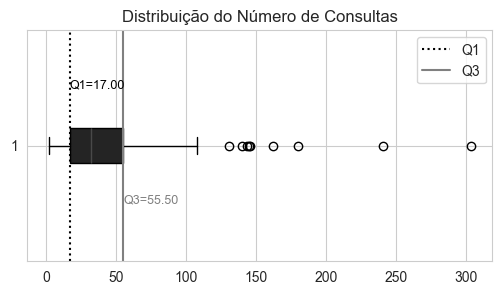

Q1: 17.0
Q3: 55.5
IQR:38.5


In [18]:
q1 = np.percentile(df_query['qnt_doc_relevant'], 25)
q3 = np.percentile(df_query['qnt_doc_relevant'], 75)
iqr = q3 - q1

plt.figure(figsize=(6, 3))
plt.boxplot(x=df_query['qnt_doc_relevant'], vert=False, patch_artist=True)
plt.axvline(q1, color='black', linestyle=':', label='Q1')
plt.axvline(q3, color='gray', linestyle='-', label='Q3')
plt.text(q1, 1.25, f'Q1={q1:.2f}', color='black', ha='left', fontsize=9)
plt.text(q3, 0.75, f'Q3={q3:.2f}', color='gray', ha='left', fontsize=9)
plt.legend()
plt.title('Distribuição do Número de Consultas')
plt.show()

print(f"Q1: {q1}\nQ3: {q3}\nIQR:{iqr}")

Como escolher um k mínimo para retorno no FAISS? 

A média de documentos não pode ser considerada boa para este tipo de base de dados, onde possui muitos outilers com valores muito alto, isso faz com que a dispersão dos dados seja alta.

Entretanto se escolhemos como limite o Q1, estaremos concentrando os resultados apenas em 25% dos dados, se esolhermos o valor de corte como Q3 satisfazemos o nível de consulta para 75% da base. Entretanto ao escolher o ponto de corte em Q1, ignoramos a representatividade de 50% dos dados, o que levaria a uma falsa precisão do sistema. Caso escolha Q3, estariamos negligenciando 25% da base de dados, buscando além do que é necessário e consequentemente trazendo lixo para os resultados.

O IQR é um número que fica entre o Q1 e o Q3, que consegue equilibrar o trade-off para o sistema entre deixar de retornar muito documento relevante e retornar irrerlevantes quando não seria necessário um grande retorno. Enteão, de acordo com a análise dessa base de dados, o mais indicado é retornar o número mínimo de 38 documentos(IQR), pois é o número que representa melhor a quantidade de documentos relevantes para cada registro no conjunto de dados completo.

# FAISS

## Functions

In [19]:
def apply_FAISS(document, d_ids, query, q_ids, k_nearest):
    
    initial_time = time.time()
    
    dim =  document.shape[1]
    document = np.asarray(document, dtype='float32')
    query = np.asarray(query, dtype='float32')

    faiss.normalize_L2(document)
    index = faiss.IndexFlatIP(dim)
    index = faiss.IndexIDMap(index)
    index.add_with_ids(document, d_ids)

    
    search_query = query.copy().astype(np.float32)
    faiss.normalize_L2(search_query)

    similarities, similarities_id = index.search( search_query, k=k_nearest )
    similarities = np.around(np.clip(similarities, 0, 1), decimals=4)


    result = []
    for i, q_id in enumerate( q_ids ):
        
        neighbors = similarities_id[i]
        dist_neighbors = similarities[i]
        result.append({ 'id_query': q_id,
                        'doc_retrieval': neighbors,
                        'dist': dist_neighbors})
        
    print(f"Execution Time = {np.around(time.time() - initial_time, decimals=4)}s")

    return pd.DataFrame(result)

In [20]:
document_ids = df_data_pp['id_document'].to_list()
query_ids =  df_query_pp['id_query'].to_list()

# Vector TF-IDF
print("FAISS FlatIP TF-IDF:")
result_v = apply_FAISS(v_document, document_ids, v_query, query_ids, 38)

# Embeddings
print("FAISS FlatIP Embeddings:")
result_e = apply_FAISS(e_document, document_ids, e_query, query_ids, 38)

FAISS FlatIP TF-IDF:
Execution Time = 0.1282s
FAISS FlatIP Embeddings:
Execution Time = 0.004s


# Evaluation

## Functions

In [21]:
def caclulate_dist_stats(data, col_dist):

    data['dist_min'] = data[col_dist].apply(lambda x: min(x))
    data['dist_max'] = data[col_dist].apply(lambda x: max(x))
    data['dist_mean'] = data[col_dist].apply(lambda x: statistics.mean(x))
    data['dist_median'] = data[col_dist].apply(lambda x: statistics.median(x))
    data['dist_std'] = data[col_dist].apply(lambda x: statistics.stdev(x)) 
    
    return data

def calculate_precision_recall_complete(data):
    
    precision_recall_list = []

    for row in data.iterrows():

        id_query = row[1]['id_query']
        qnt_doc_relevant = row[1]['qnt_doc_relevant']
        doc_relevant = set(row[1]['doc_relevant'])
        doc_retrieval = set(row[1]['doc_retrieval'])

        precision = len(doc_relevant.intersection(doc_retrieval)) / len(doc_retrieval) if len(doc_retrieval) > 0 else 0
 
        recall = len(doc_relevant.intersection(doc_retrieval)) / qnt_doc_relevant

        precision_recall_list.append({
            'id_query': id_query,
            'precision_general': float(f"{precision:.2f}"),
            'recall_general': float(f"{recall:.2f}"),
            'doc_retrieval': list(doc_retrieval)
        })

    return pd.DataFrame(precision_recall_list)

def calculate_precision_recall_by_level(df: pd.DataFrame) -> pd.DataFrame:
    
    result = []

    for _, row in df.iterrows():
        id_query = row['id_query']
        total_retrieval = row['doc_retrieval']

        # Itera pelos níveis especificados
        for level in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            # Calcula a quantidade de elementos a serem considerados
            qnt_elements = int(len(total_retrieval) * level)
            doc_retrieval_it = total_retrieval[:qnt_elements]

            # Documentos relevantes na iteração atual
            doc_relevant_it = set(row['doc_relevant'][:qnt_elements])

            # Cálculo da interseção entre documentos recuperados e relevantes
            intersection = set(doc_retrieval_it).intersection(set(row['doc_relevant']))

            # Cálculo da precisão (precision) e recall
            precision = len(intersection) / len(doc_retrieval_it) if len(doc_retrieval_it) > 0 else 0
            recall = len(intersection) / len(doc_relevant_it) if len(doc_relevant_it) > 0 else 0

            result.append({
                'id_query': id_query,
                'percent_retrieval': level * 100,
                'precision': float(f"{precision:.2f}"),
                'recall': float(f"{recall:.2f}"),
                'doc_retrieval': doc_retrieval_it
            })

    return pd.DataFrame(result)

def find_first_position(relevant, retrieval):

    for i, element in enumerate(retrieval):
        if element in relevant:
            return i  # Retorna a posição onde o element foi encontrado em l2

    return -1  # Retorna None se nenhum element de l2 estiver em l1

def calculate_rr(scorrect, sh):
    if scorrect <= sh:
        return 1
    else:
        return 0

def calculate_mrr(data, threshold):  
          
    total_mrr = 0.0
    num_queries = len(data)

    for row in data.iterrows() :
        scorrect = row[1]['first_position']
        rr = calculate_rr(scorrect, threshold)
        total_mrr += rr

    mrr = total_mrr / num_queries
    
    return mrr

def precision_at_k(relevant_docs, retrieved_docs, k):

    # Considera apenas os primeiros k documentos recuperados
    retrieved_docs_at_k = retrieved_docs[:k]

    # Calcula a interseção entre documentos relevantes e recuperados até k
    intersection = set(relevant_docs).intersection(set(retrieved_docs_at_k))

    # Calcula a precisão em k
    precision = len(intersection) / k if k > 0 else 0

    return precision

In [22]:
result_e = pd.merge(result_e, df_query[['id_query','qnt_doc_relevant', 'doc_relevant']], on='id_query')
result_e = caclulate_dist_stats(result_e, 'dist')
result_e.head()

,id_query,doc_retrieval,dist,qnt_doc_relevant,doc_relevant,dist_min,dist_max,dist_mean,dist_median,dist_std
0,1,"[827, 461, 533, 960, 454, 484, 437, 741, 975, ...","[0.5072, 0.495, 0.4834, 0.4661, 0.4458, 0.4328...",34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",0.3140,0.5072,0.3743,0.3587,0.0531
1,2,"[975, 437, 151, 592, 439, 265, 980, 114, 805, ...","[0.5501, 0.5232, 0.5116, 0.4972, 0.4853, 0.478...",7,"[169, 434, 454, 498, 499, 592, 875]",0.3740,0.5501,0.4287,0.4160,0.0466
2,3,"[439, 445, 633, 856, 256, 1175, 1125, 374, 500...","[0.5802, 0.5449, 0.5203, 0.52, 0.5097, 0.5033,...",43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",0.4289,0.5802,0.4678,0.4545,0.0355
3,4,"[604, 374, 876, 711, 539, 439, 278, 441, 669, ...","[0.5452, 0.4962, 0.4946, 0.4833, 0.4706, 0.470...",9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",0.4038,0.5452,0.4349,0.4233,0.0331
4,5,"[867, 501, 975, 439, 437, 559, 499, 875, 498, ...","[0.6094, 0.5658, 0.5657, 0.5538, 0.5413, 0.540...",131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",0.4410,0.6094,0.4877,0.4815,0.0428


In [23]:
result_v = pd.merge(result_v, df_query[['id_query','qnt_doc_relevant', 'doc_relevant']], on='id_query')
result_v = caclulate_dist_stats(result_v, 'dist')
result_v.head()

,id_query,doc_retrieval,dist,qnt_doc_relevant,doc_relevant,dist_min,dist_max,dist_mean,dist_median,dist_std
0,1,"[484, 437, 499, 741, 498, 827, 957, 592, 533, ...","[0.2589, 0.2539, 0.2303, 0.2285, 0.2232, 0.212...",34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",0.1023,0.2589,0.1597,0.1550,0.0432
1,2,"[592, 498, 980, 754, 481, 499, 925, 114, 711, ...","[0.4275, 0.2099, 0.1887, 0.1755, 0.1749, 0.166...",7,"[169, 434, 454, 498, 499, 592, 875]",0.0629,0.4275,0.1145,0.0877,0.0653
2,3,"[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1...","[0.4266, 0.3923, 0.3166, 0.2955, 0.2588, 0.242...",43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",0.1222,0.4266,0.1888,0.1656,0.0707
3,4,"[715, 604, 357, 876, 725, 1030, 928, 662, 1039...","[0.4011, 0.3433, 0.2904, 0.281, 0.2766, 0.2751...",9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",0.1144,0.4011,0.1815,0.1650,0.0670
4,5,"[498, 754, 499, 711, 592, 265, 975, 151, 501, ...","[0.3565, 0.3303, 0.3028, 0.2984, 0.296, 0.2706...",131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",0.1142,0.3565,0.1826,0.1468,0.0717


## Distance Analysis

In [24]:
result_e.agg({'dist_min':'min', 'dist_max':'max', 'dist_mean':'mean', 'dist_std':'mean', 'dist_median':'mean'})

dist_min      0.1833
dist_max      0.7553
dist_mean     0.4384
dist_std      0.0401
dist_median   0.4272
dtype: float64

In [25]:
result_v.agg({'dist_min':'min', 'dist_max':'max', 'dist_mean':'mean', 'dist_std':'mean', 'dist_median':'mean'})

dist_min      0.0330
dist_max      0.6535
dist_mean     0.1408
dist_std      0.0573
dist_median   0.1224
dtype: float64

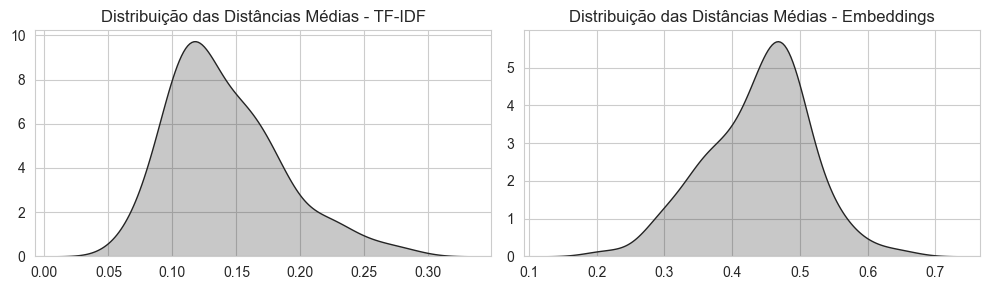

In [26]:
palette_cinza = sns.color_palette("gray")

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.kdeplot(result_v['dist_mean'], fill=True, ax=axes[0], color=palette_cinza[0])
axes[0].set_title('Distribuição das Distâncias Médias - TF-IDF')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

sns.kdeplot(result_e['dist_mean'], fill=True, ax=axes[1], color=palette_cinza[0])
axes[1].set_title('Distribuição das Distâncias Médias - Embeddings')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()

plt.show()

## Precision and Recall

In [27]:
pr_complete_e = calculate_precision_recall_complete(result_e)
pr_complete_v = calculate_precision_recall_complete(result_v)
pr_complete_e.head()

,id_query,precision_general,recall_general,doc_retrieval
0,1,0.2100,0.2400,"[265, 1034, 139, 140, 147, 533, 1185, 40, 430,..."
1,2,0.0800,0.4300,"[265, 915, 788, 533, 151, 1175, 1049, 23, 925,..."
2,3,0.3400,0.3000,"[256, 644, 520, 139, 269, 401, 1175, 23, 412, ..."
3,4,0.1300,0.5600,"[1030, 787, 278, 1050, 539, 924, 669, 283, 287..."
4,5,0.5300,0.1500,"[776, 265, 913, 915, 533, 151, 805, 1192, 297,..."


In [28]:
"Embeddings", pr_complete_e[['precision_general', 'recall_general']].mean(), "TF-IDF", pr_complete_v[['precision_general', 'recall_general']].mean()

('Embeddings',
 precision_general   0.2464
 recall_general      0.2665
 dtype: float64,
 'TF-IDF',
 precision_general   0.2596
 recall_general      0.2929
 dtype: float64)

## Precision at k

In [29]:
k = 5
result_e[f'P@{k}'] = result_e.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)
result_v[f'P@{k}'] = result_v.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)

k = 10
result_e[f'P@{k}'] = result_e.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)
result_v[f'P@{k}'] = result_v.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)

"Embeddings", result_e[['P@5', 'P@10']].mean(),  "TF-IDF", result_v[['P@5', 'P@10']].mean()

('Embeddings',
 P@5    0.4700
 P@10   0.3930
 dtype: float64,
 'TF-IDF',
 P@5    0.5220
 P@10   0.4600
 dtype: float64)

## R-precision

In [30]:
pr_level_e = calculate_precision_recall_by_level(result_e)
pr_level_v = calculate_precision_recall_by_level(result_v)

"Embeddings", pr_level_e['precision'].mean(), "TF-IDF",pr_level_v['precision'].mean()

('Embeddings', 0.33596000000000004, 'TF-IDF', 0.37452)

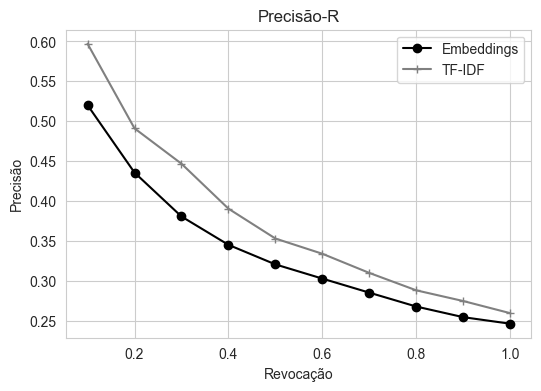

In [31]:
graph_e = pr_level_e.groupby(by="percent_retrieval")[['precision', 'recall']].mean()
graph_v = pr_level_v.groupby(by="percent_retrieval")[['precision', 'recall']].mean()

plt.figure(figsize=(6, 4))
plt.plot(graph_e.index/100, graph_e['precision'], marker='o', linestyle='-', color='black', label='Embeddings')
plt.plot(graph_v.index/100, graph_v['precision'], marker='+', linestyle='-',  color='gray', label='TF-IDF')

plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.title('Precisão-R')

# Exibir o gráfico
plt.legend()
plt.grid(True)
plt.show()

## MRR(Q) Sh=5

In [32]:
result_e['first_position'] = result_e.apply(lambda row: find_first_position(row['doc_relevant'], row['doc_retrieval']), axis=1)
result_v['first_position'] = result_v.apply(lambda row: find_first_position(row['doc_relevant'], row['doc_retrieval']), axis=1)

result_e.query('first_position == -1').shape, result_v.query('first_position == -1').shape

((3, 13), (1, 13))

In [33]:
mrr_e = calculate_mrr(result_e, 5)
mrr_v = calculate_mrr(result_v, 5)
print(f"Mrr(Q)\nEmbedings {mrr_e}\nVectorize {mrr_v}")

Mrr(Q)
Embedings 0.88
Vectorize 0.93


## Histogram TOP-20 

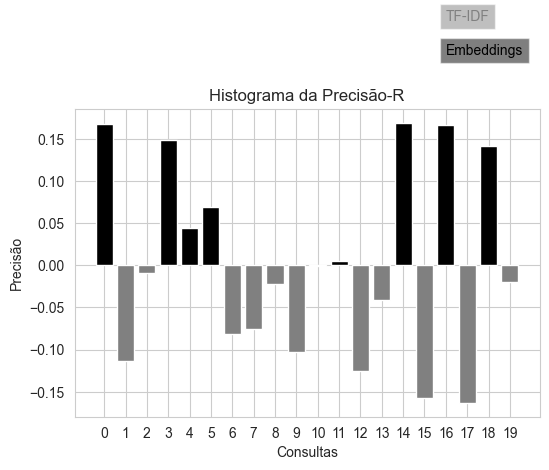

In [34]:
sist_e = pr_level_e.query("id_query <= 20 ").groupby("id_query")['precision'].mean().reset_index()
sist_v = pr_level_v.query("id_query <= 20 ").groupby("id_query")['precision'].mean().reset_index()

r_precision = sist_e['precision'] - sist_v['precision']
r_precision = r_precision.reset_index()
r_precision = r_precision.astype({'index':str})

colors = ['gray' if val < 0 else 'black' for val in r_precision['precision']]
plt.figure(figsize=(6, 4))
plt.bar(x=r_precision['index'], height=r_precision['precision'], color=colors)
# Adicionar rótulos e título
plt.grid(True)
plt.xlabel('Consultas')
plt.ylabel('Precisão')
plt.title('Histograma da Precisão-R')

# Adicionar anotações para os grupos
plt.text(16, 0.29, 'TF-IDF', color='gray', bbox=dict(facecolor='gray', alpha=0.5))
plt.text(16, 0.25, 'Embeddings', color='black', bbox=dict(facecolor='black', alpha=0.5))

# Exibir o gráfico
plt.show()